# MRI and Alzheimers 
## Using Longitudinal MRI Data in Nondemented and Demented Older Adults to Predict Dementia
### Huiyu (Shirley) Sun 
##### May 9, 2019

## Import Dataset
###### The Open Access Series of Imaging Studies (OASIS) is a series of MRI data sets that is publicly available for study and analysis. The present data set consists of a longitudinal collection of 151 subjects aged 60 to 98. Each subject was scanned on two or more visits, separated by at least one year. All subjects were characterized using the Clinical Dementia Rating (CDR) are either nondemented or with very mild to mild dementia of the Alzheimer&#146;s type (DAT). 77 of the subjects were characterized as nondemented at the time of each of their visits. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans. Another 10 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at the time of one or more later visits. The subjects were all right-handed and include both men (n=62) and women (n=89). For each scanning session, 3 or 4 individual T1-weighted MRI scans were obtained. Multiple within-session acquisitions provide extremely high contrast-to-noise making the data amenable to a wide range of analytic approaches including automated computational analysis. Automated calculation of whole brain volume and estimated total intracranial volume are presented to demonstrate use of the data for measuring differences associated with normal aging and Alzheimer&#146;s disease.

#### Data Features (151 subjects)
- Subject ID
- MRI ID
- Visit
- MR Delay
###### Demographic
- M/F
- Hand (R)
- Age (60 - 98)
- EDUC (years)
- SES - Socioeconomic status 1: less than high school grad., 2: high school grad., 3: some college, 4: college grad., 5: beyond college.
###### Clinical
- MMSE - Mini-Mental State Examination
- CDR - Clinical Dementia Rating (CDR; 0 = nondemented; 0.5 = very mild dementia; 1 = mild dementia; 2 = moderate dementia) (Morris, 1993). All participants with dementia (CDR >0) were diagnosed with probable AD.
###### Derived anatomic volumes
- eTIV - Estimated total intracranial volume
- nWBV - Normalized whole brain volume
- ASF - Atlas scaling factor
- Group - Demented, Nondemented, Converted (y)

In [10]:
# This project is trying to find the best method to predict whether the patient will get
# Dementia/Alzheimers or not given the data
# Data should not be combined, each dataset should not be used individually only.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

mri_long = pd.read_csv('oasis_longitudinal.csv', sep = ',')
mri_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [11]:
# closer look to the score and labels
mri_long.groupby(['CDR', 'Group']).size().unstack()

Group,Converted,Demented,Nondemented
CDR,,,
0.0,18.0,NaN,188.0
0.5,19.0,102.0,2.0
1.0,NaN,41.0,NaN
2.0,NaN,3.0,NaN


In [12]:
mri_long.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

## Pre-Process

In [13]:
# the data contains more than one visits, we only keep single visit = 1
# no converted patients included
# MR Delay == 0
# df = mri_long.loc[mri_long['Visit'] == 1]
df = mri_long
df = df.drop(['Subject ID', 'MRI ID', 'Hand', 'MR Delay'], axis = 1)
display(df.head(), df.shape)

,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,Demented,1,M,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,Demented,2,M,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,Demented,3,M,80,12,NaN,22.0,0.5,1698,0.701,1.034


(373, 11)

In [14]:
# missing values at the initial Visit
# SES (Socioeconomics Status)
df.isnull().sum()

Group     0
Visit     0
M/F       0
Age       0
EDUC      0
SES      19
MMSE      2
CDR       0
eTIV      0
nWBV      0
ASF       0
dtype: int64

In [15]:
from sklearn.preprocessing import LabelEncoder

# 0.0 (0), 0.5 (1), 1 (2)
df['CDR_code']= LabelEncoder().fit_transform(df['CDR'])

In [16]:
# MMSE Scores Mini-Mental State Examination - Ordinal
# Ref: https://www.heartandstroke.ca/-/media/pdf-files/canada/clinical-update/allen-huang-cognitive-screening-toolkit.ashx?la=en&hash=631B35521724C28268D0C2130D07A401E33CDBB0
# 25-30 (Questionably significant); 20-25 (Mild); 10-20 (Moderate); 0-10 (Severe)
def mmse_group(col):
    if col <= 10:
        return "Severe"
    elif 10 < col <= 20:
        return "Moderate"
    elif 20 < col <= 25:
        return "Mild"
    elif 25 < col <= 30:
        return "Questionably significant"
    else:
        return "missing"

def mmse_code(col):
    if col <= 10:
        return "3"
    elif 10 < col <= 20:
        return "2"
    elif 20 < col <= 25:
        return "1"
    elif 25 < col <= 30:
        return "0"
    else:
        return "-1"
df['MMSE Group'] = df['MMSE'].apply(mmse_group)
df['MMSE Group'].value_counts(sort = True)

df['MMSE_code'] = df['MMSE'].apply(mmse_code)
df.head()

,Group,Visit,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,CDR_code,MMSE Group,MMSE_code
0,Nondemented,1,M,87,14,2.0,27.0,0.0,1987,0.696,0.883,0,Questionably significant,0
1,Nondemented,2,M,88,14,2.0,30.0,0.0,2004,0.681,0.876,0,Questionably significant,0
2,Demented,1,M,75,12,NaN,23.0,0.5,1678,0.736,1.046,1,Mild,1
3,Demented,2,M,76,12,NaN,28.0,0.5,1738,0.713,1.010,1,Questionably significant,0
4,Demented,3,M,80,12,NaN,22.0,0.5,1698,0.701,1.034,1,Mild,1


In [17]:
# M/F F = 0, M = 1
df['Gender_code'] = LabelEncoder().fit_transform(df['M/F'])

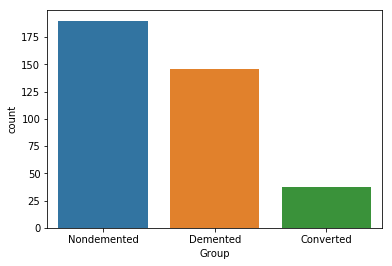

In [18]:
# Demented > ND at patients' initial visit
sns.countplot(x = 'Group', data = df)

In [45]:
# Group Demented = 0, Nondemented = 1
df['Group'] = df['Group'].replace(['Converted'],['Demented'])
df['Group_code'] = LabelEncoder().fit_transform(df['Group'])

df[['M/F', 'Gender_code', 'Group', 'Group_code']].head()

,M/F,Gender_code,Group,Group_code
0,M,1,Nondemented,1
1,M,1,Nondemented,1
2,M,1,Demented,0
3,M,1,Demented,0
4,M,1,Demented,0


In [20]:
display(df.info(), df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 16 columns):
Group          373 non-null object
Visit          373 non-null int64
M/F            373 non-null object
Age            373 non-null int64
EDUC           373 non-null int64
SES            354 non-null float64
MMSE           371 non-null float64
CDR            373 non-null float64
eTIV           373 non-null int64
nWBV           373 non-null float64
ASF            373 non-null float64
CDR_code       373 non-null int64
MMSE Group     373 non-null object
MMSE_code      373 non-null object
Gender_code    373 non-null int64
Group_code     373 non-null int64
dtypes: float64(5), int64(7), object(4)
memory usage: 46.7+ KB


None

Index(['Group', 'Visit', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'CDR_code', 'MMSE Group', 'MMSE_code', 'Gender_code',
       'Group_code'],
      dtype='object')

## Data Exploration

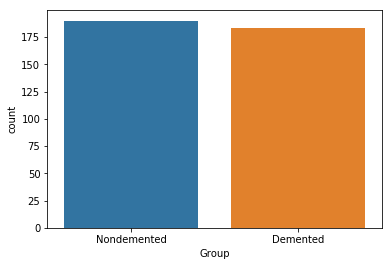

In [46]:
# converted --> Demented
sns.countplot(x = 'Group', data = df)

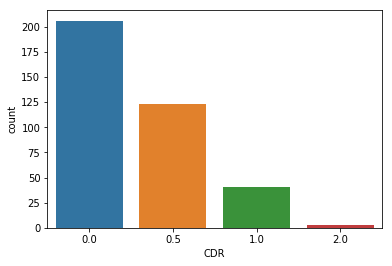

In [22]:
sns.countplot(x = 'CDR', data= df)

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


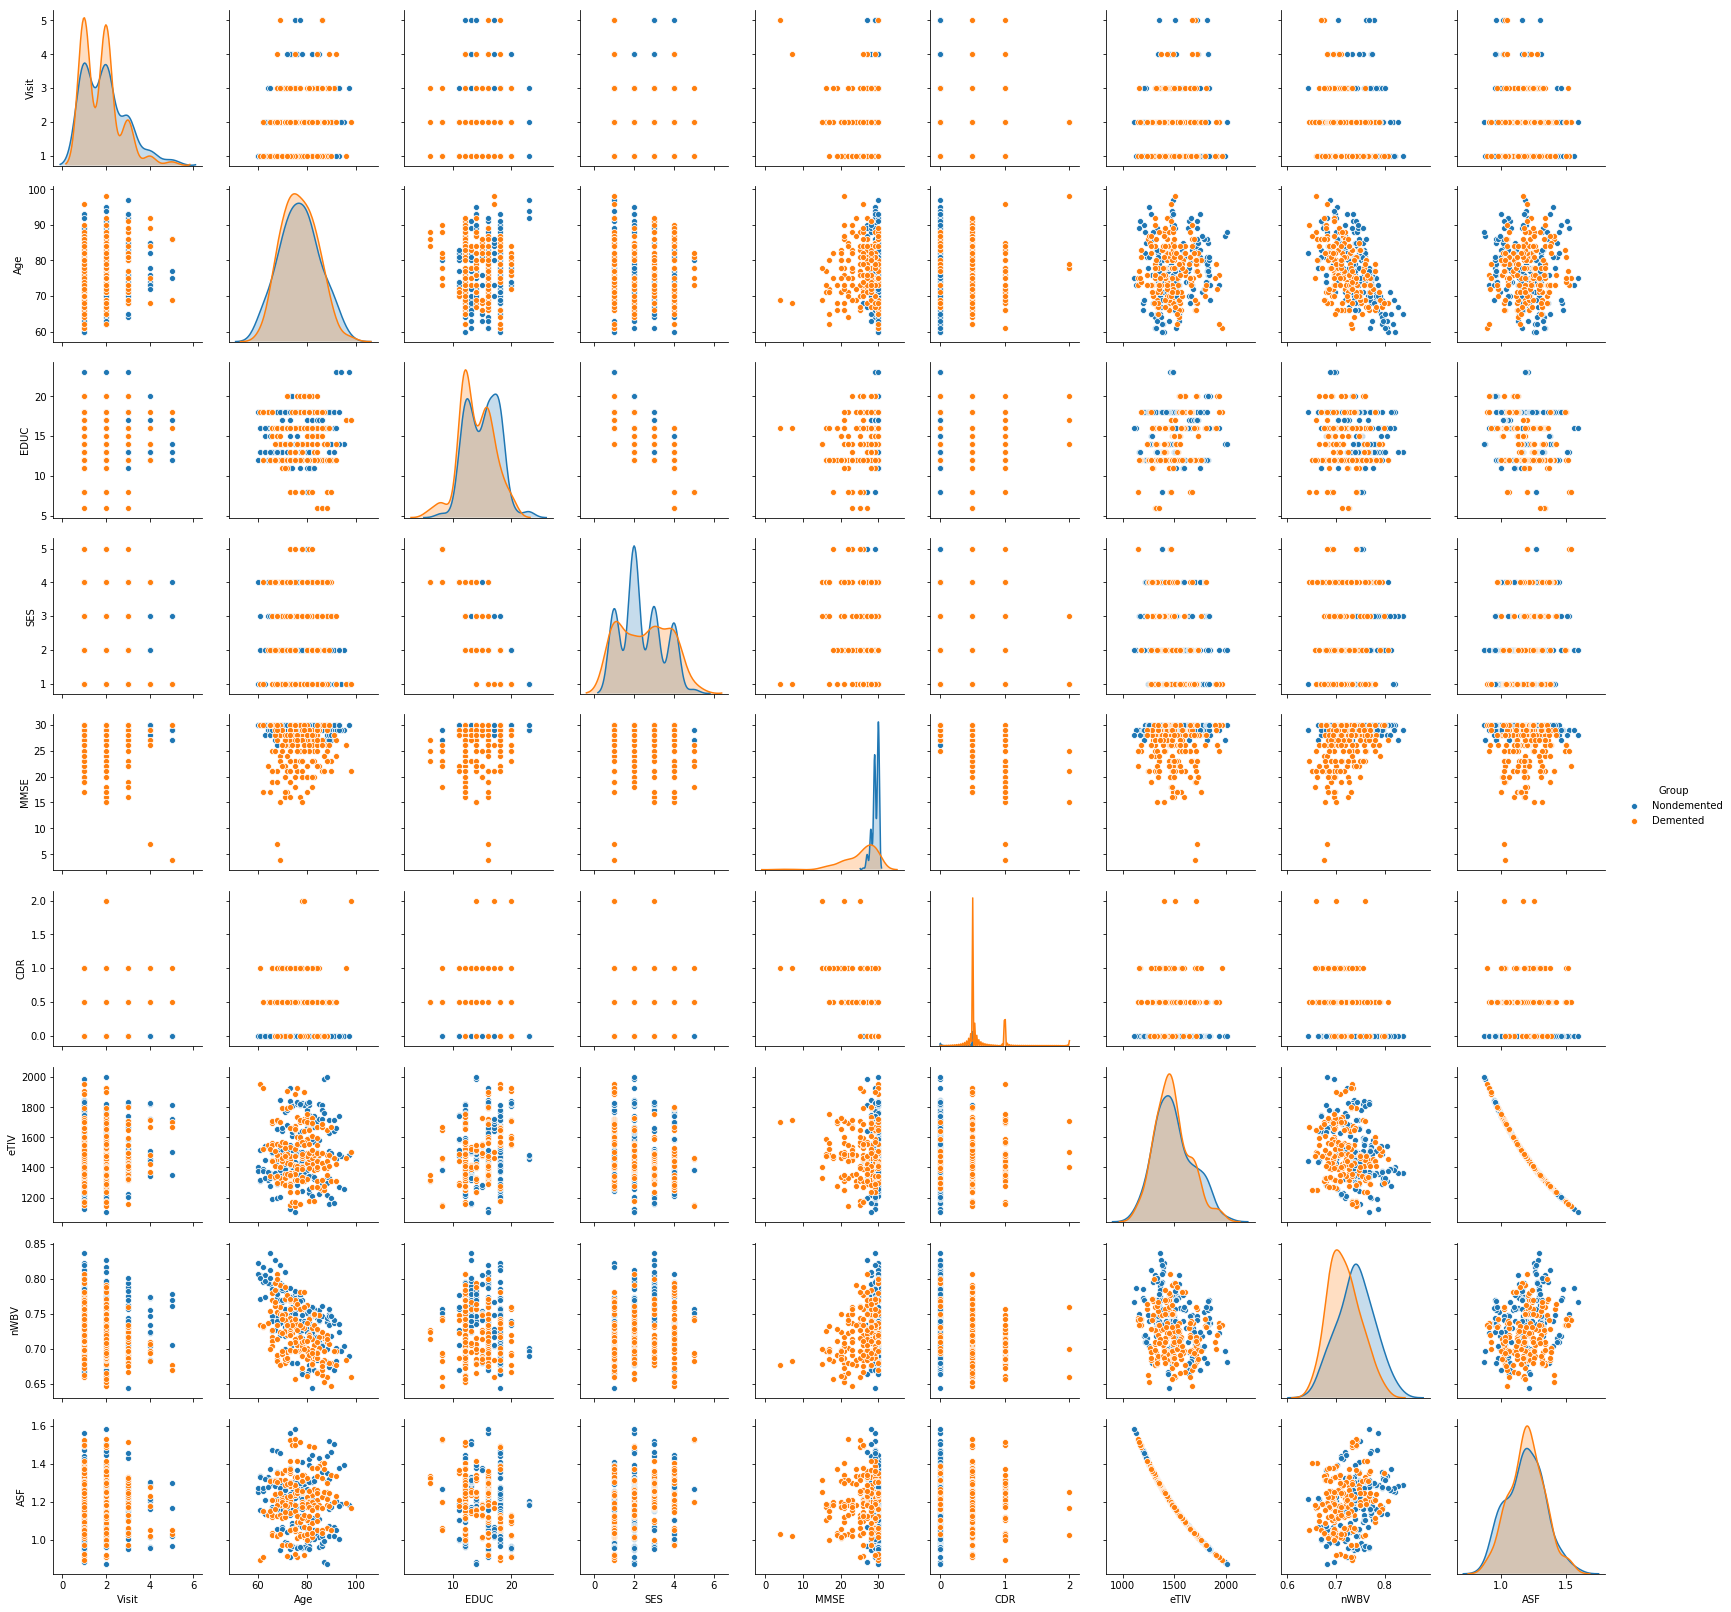

In [49]:
# multicolinearity exists
cols1 = ['Group', 'M/F', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV','ASF']
df1 = df[cols1]
sns.pairplot(df1, hue = 'Group')

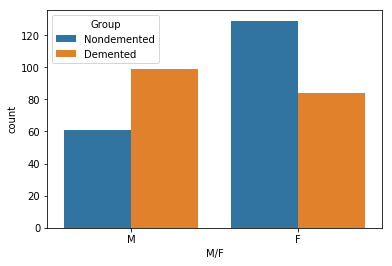

In [50]:
# Gender: M/F
# Demented male > ND male ; ND female > Demented female
# female less likely to be Demented than male
sns.countplot(x = 'M/F', hue = 'Group', data = df)

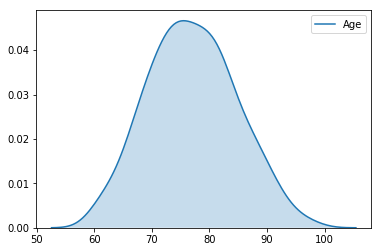

In [25]:
# Age vs Group
sns.kdeplot(df['Age'], shade = True)

### Remove NA & Impute

In [26]:
# remove NA
df_rmna = df.dropna()

# impute 
# df_ipna = df.

### Normalization

In [27]:
# recoded categorical varibles (Group_code)
# Group, M/F nominal
# CDR ordinal
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE_code', 'CDR_code', 'eTIV', 'nWBV', 'ASF']
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR_code', 'eTIV', 'nWBV', 'ASF']
x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

X = df_rmna[x_cols]
y = df_rmna['Group_code'].astype('category')

## Modeling

In [28]:
# decision tree
# random forest
# SVM
# logistic regression
# KNN (handles nonlinearity)
# loss function (measures how good we predict each example, SSE commonly used)
# cost function (loss function for all training examples, MSE)
# minimize cost function by solving an optimize problem
# gradient descent: gradient shows the direction towards the minimum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

num_cols = ['Visit', 'Age', 'EDUC', 'SES', 'eTIV', 'nWBV', 'ASF', 'MMSE']

# normalization
# training set
X_train_norm = StandardScaler().fit_transform(X_train[num_cols])
training_norm_col = pd.DataFrame(X_train_norm, index = X_train[num_cols].index, columns = X_train[num_cols].columns)
X_train.update(training_norm_col)

# test set
X_test_norm = StandardScaler().fit_transform(X_test[num_cols])
test_norm_col = pd.DataFrame(X_test_norm, index = X_test[num_cols].index, columns = X_test[num_cols].columns)
X_test.update(test_norm_col)

# whole set
X_norm = StandardScaler().fit_transform(X[num_cols])
norm_col = pd.DataFrame(X_norm, index = X[num_cols].index, columns = X[num_cols].columns)
X.update(norm_col)


X_train.shape, y_train.shape

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler

((237, 9), (237,))

In [29]:
X_test.head()

,Gender_code,Visit,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
230,1,0.149565,0.800776,-1.230392,1.466054,0.414624,1.484825,-1.611983,-1.388051
48,0,0.149565,-0.776068,-0.897930,0.533835,0.693423,-0.705987,1.487111,0.660120
298,0,0.149565,-0.513260,0.431916,0.533835,0.414624,-1.122469,1.182735,1.184739
189,1,-0.944131,-0.513260,1.096839,-0.398384,0.414624,0.366598,1.238076,-0.468171
62,0,-0.944131,0.275161,0.431916,-1.330603,0.414624,-0.101231,-0.698857,-0.015417


In [30]:
X_test.shape, y_test.shape

((117, 9), (117,))

In [31]:
# logistic regression
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import cross_val_score, KFold

lr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)

se_lr = np.round(mean_squared_error(y_test, y_predict),2)
acc_lr = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_lr)
print('Accuracy:', acc_lr)

MSE: 0.17
Accuracy: 0.83


In [32]:
# CV
lr.fit(X, y)
y_predict = lr.predict(X)

cv = KFold(n_splits=5, shuffle=True, random_state=10)
se = abs(np.mean(cross_val_score(lr, X, y, cv=cv, scoring="neg_mean_squared_error")))
acc = abs(np.mean(cross_val_score(lr, X, y, cv=cv, scoring="accuracy")))
print('MSE: ', np.round(se, 2))
print('Accuracy: ', np.round(acc, 2))

MSE:  0.21
Accuracy:  0.79


In [33]:
# lasso
llr = Lasso(alpha=0.5)
llr.fit(X, y)
preds = llr.predict(X)

# Create the CV iterator
cv = KFold(n_splits=5, shuffle=True, random_state=10)
abs(np.mean(cross_val_score(llr, X, y, cv=cv, scoring="neg_mean_squared_error"))) 

0.25006516845550875

In [34]:
# Ridge regression
from sklearn.linear_model import Ridge

llr = Ridge(alpha=0.5)
llr.fit(X, y)
preds = llr.predict(X)

# Create the CV iterator
cv = KFold(n_splits=5, shuffle=True, random_state=10)
abs(np.mean(cross_val_score(llr, X, y, cv=cv, scoring="neg_mean_squared_error")))

0.16679795506097936

MSE: 0.23
Accuracy: 0.77


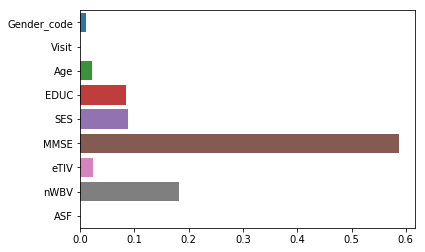

In [35]:
# Decision Tree 
from sklearn.tree import DecisionTreeClassifier

dtr = DecisionTreeClassifier(max_depth = 5, random_state = 0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)

se_dtr = np.round(mean_squared_error(y_test, y_predict),2)
acc_dtr = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_dtr)
print('Accuracy:', acc_dtr)

fea_ip = dtr.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

In [36]:
# CV
dtr.fit(X, y)

cv = KFold(n_splits=5, shuffle=True, random_state=10)
se = abs(np.mean(cross_val_score(dtr, X, y, cv=cv, scoring="neg_mean_squared_error")))
acc = abs(np.mean(cross_val_score(dtr, X, y, cv=cv, scoring="accuracy")))
print('MSE: ', np.round(se, 2))
print('Accuracy: ', np.round(acc, 2))

MSE:  0.24
Accuracy:  0.76


MSE: 0.21
Accuracy: 0.79


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


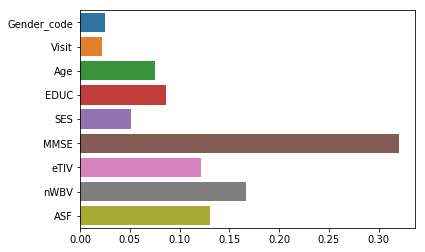

In [37]:
# Random Forest (bagging)
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(random_state = 123)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
mean_squared_error(y_test, y_predict)

se_rf = np.round(mean_squared_error(y_test, y_predict),2)
acc_rf = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_rf)
print('Accuracy:', acc_rf)

fea_ip = rf.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

In [38]:
# CV
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor()
abs(np.mean(cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error")))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

0.1907006036217304

MSE: 0.14
Accuracy: 0.86


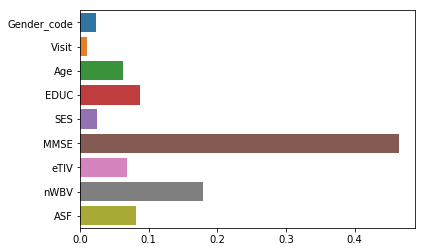

In [39]:
# Gradient Boosting (boosting)
# sequential improvement of models by training on their errors
# improves errors, one tree each step
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = 0)
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
mean_squared_error(y_test, y_predict)

se_gb = np.round(mean_squared_error(y_test, y_predict),2)
acc_gb = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_gb)
print('Accuracy:', acc_gb)

fea_ip = gb.feature_importances_
sns.barplot(x = fea_ip, y = X.columns)

In [40]:
# SVM
from sklearn.svm import SVC

clf = SVC(gamma='auto', random_state = 123)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

se_clf = np.round(mean_squared_error(y_test, y_predict),2)
acc_clf = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_clf)
print('Accuracy:', acc_clf)

MSE: 0.21
Accuracy: 0.79


In [41]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

y_predict = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train).predict(X_test)

se_knn = np.round(mean_squared_error(y_test, y_predict),2)
acc_knn = np.round(accuracy_score(y_test, y_predict),2)
print('MSE:', se_knn)
print('Accuracy:', acc_knn)

MSE: 0.26
Accuracy: 0.74


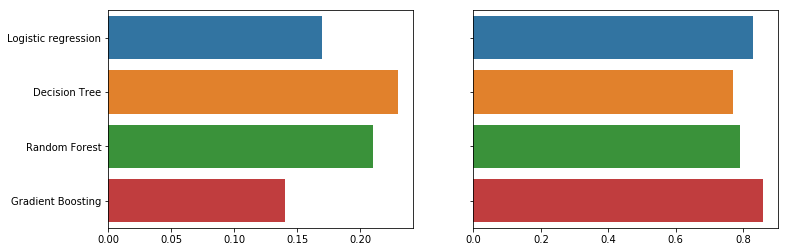

In [42]:
# visualize all methods
methods = ['Logistic regression','Decision Tree', 'Random Forest', 'Gradient Boosting']
se = [se_lr, se_dtr, se_rf, se_gb]
acc = [acc_lr, acc_dtr, acc_rf, acc_gb]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
sns.barplot(x = se, y = methods, ax = ax1)
sns.barplot(x = acc, y = methods, ax = ax2)

### Non-normalization

In [43]:
from sklearn.model_selection import train_test_split

x_cols = ['Gender_code', 'Visit', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

X = df_rmna[x_cols]
y = df_rmna['Group_code']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# logistic regression
lr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
mean_squared_error(y_test, y_predict)

0.1794871794871795

In [44]:
X_train.head()

,Gender_code,Visit,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
110,1,1,74,18,2.0,29.0,1463,0.737,1.199
286,0,2,78,16,3.0,27.0,1393,0.690,1.260
124,1,2,79,14,3.0,26.0,1308,0.706,1.341
37,1,2,82,20,1.0,28.0,1606,0.677,1.093
42,0,2,64,16,3.0,29.0,1316,0.796,1.333
